In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import *

In [2]:
g1 = ['Uttarakhand', 'Sikkim','Arunachal Pradesh','Assam','Manipur','Meghalaya','Mizoram','Nagaland','Tripura', 'Kerala', 'Goa', 'Delhi', 'Jammu and Kashmir', 'Himachal Pradesh', 'Chandigarh']
g2 = ['Rajasthan', 'Madhya Pradesh', 'Karnataka', 'Gujarat', 'Tamil Nadu']
g3 = ['West Bengal', 'Telangana','Bihar', 'Punjab', 'Odisha', 'Jharkhand', 'Haryana', 'Chhattisgarh', 'Andhra Pradesh']
g4 = ['Uttar Pradesh', 'Maharashtra']

all_groups = g1 + g2 + g3 + g4

In [3]:
df = pd.read_csv('elec1_new_Copy.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df[all_groups]
print(df.head())

            Uttarakhand  Sikkim  Arunachal Pradesh  Assam  Manipur  Meghalaya  \
date                                                                            
2013-01-04         27.3     1.1                1.4   16.0      0.8        4.2   
2013-02-04         27.6     1.2                1.2   16.8      1.2        4.4   
2013-03-04         29.0     1.3                1.1   16.3      1.2        4.5   
2013-04-04         28.5     1.3                0.9   16.1      1.2        4.3   
2013-05-04         29.4     0.9                1.0   15.2      1.3        4.2   

            Mizoram  Nagaland  Tripura  Kerala  ...  Telangana  Bihar  Punjab  \
date                                            ...                             
2013-01-04      1.1       1.2      3.5    56.0  ...        0.0   32.7    92.3   
2013-02-04      1.0       1.2      2.9    57.6  ...        0.0   30.3    97.8   
2013-03-04      1.0       1.0      2.6    59.5  ...        0.0   29.5    98.4   
2013-04-04      1.0       1

In [4]:
for i in range(len(df.columns)):
    for j in range(len(df)):
        if df.columns[i] not in ['J&K', 'Telengana'] and df.iloc[j,i]==0:
            df.iloc[j,i] = df.iloc[j-1,i]

In [5]:
# for col in df.columns:
#     print(col)
#     plt.plot(df[col])
#     plt.show()

In [6]:
sol = pd.read_csv('SOL_State.csv')
sol['date'] = pd.to_datetime(sol['date'])
sol = sol.pivot(index='date', columns='region', values='sol')
sol = sol[all_groups] 

In [7]:
sol.index = pd.to_datetime(sol.index)
date_range = pd.date_range(start=sol.index.min().date(), end=sol.index.max().date())

missing_dates = []
for date in date_range:
    if date not in sol.index.date:
        missing_dates.append(date)

for missing_date in missing_dates:
    sol.loc[missing_date] = 0

sol.sort_index(inplace=True)

C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\3459179468.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if date not in sol.index.date:


In [8]:
for i in range(len(sol.columns)):
    for j in range(len(sol)):
        if sol.iloc[j,i]==0:
            sol.iloc[j,i] = sol.iloc[j-1,i]

In [9]:
for col in sol.columns:
    Q1 = sol[col].quantile(0.25)
    Q3 = sol[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (sol[col] < lower_bound) | (sol[col] > upper_bound)

    idx = sol.columns.get_loc(col)

    for i in range(len(sol)):
        if sol.iloc[i,idx] > upper_bound:
            sol.iloc[i,idx] = (sol.iloc[i-1,idx]+sol.iloc[i+1,idx])/2

In [10]:
clus1 = pd.read_csv('cluster1.csv')
clus2 = pd.read_csv('cluster2.csv')
clus3 = pd.read_csv('cluster3.csv')
clus4 = pd.read_csv('cluster4.csv')


date_range = pd.date_range(start='2013-04-01', end='2023-12-31')
clus1['date'] = date_range
clus2['date'] = date_range
clus3['date'] = date_range
clus4['date'] = date_range

clus1.set_index('date', inplace=True)
clus2.set_index('date', inplace=True)
clus3.set_index('date', inplace=True)
clus4.set_index('date', inplace=True)

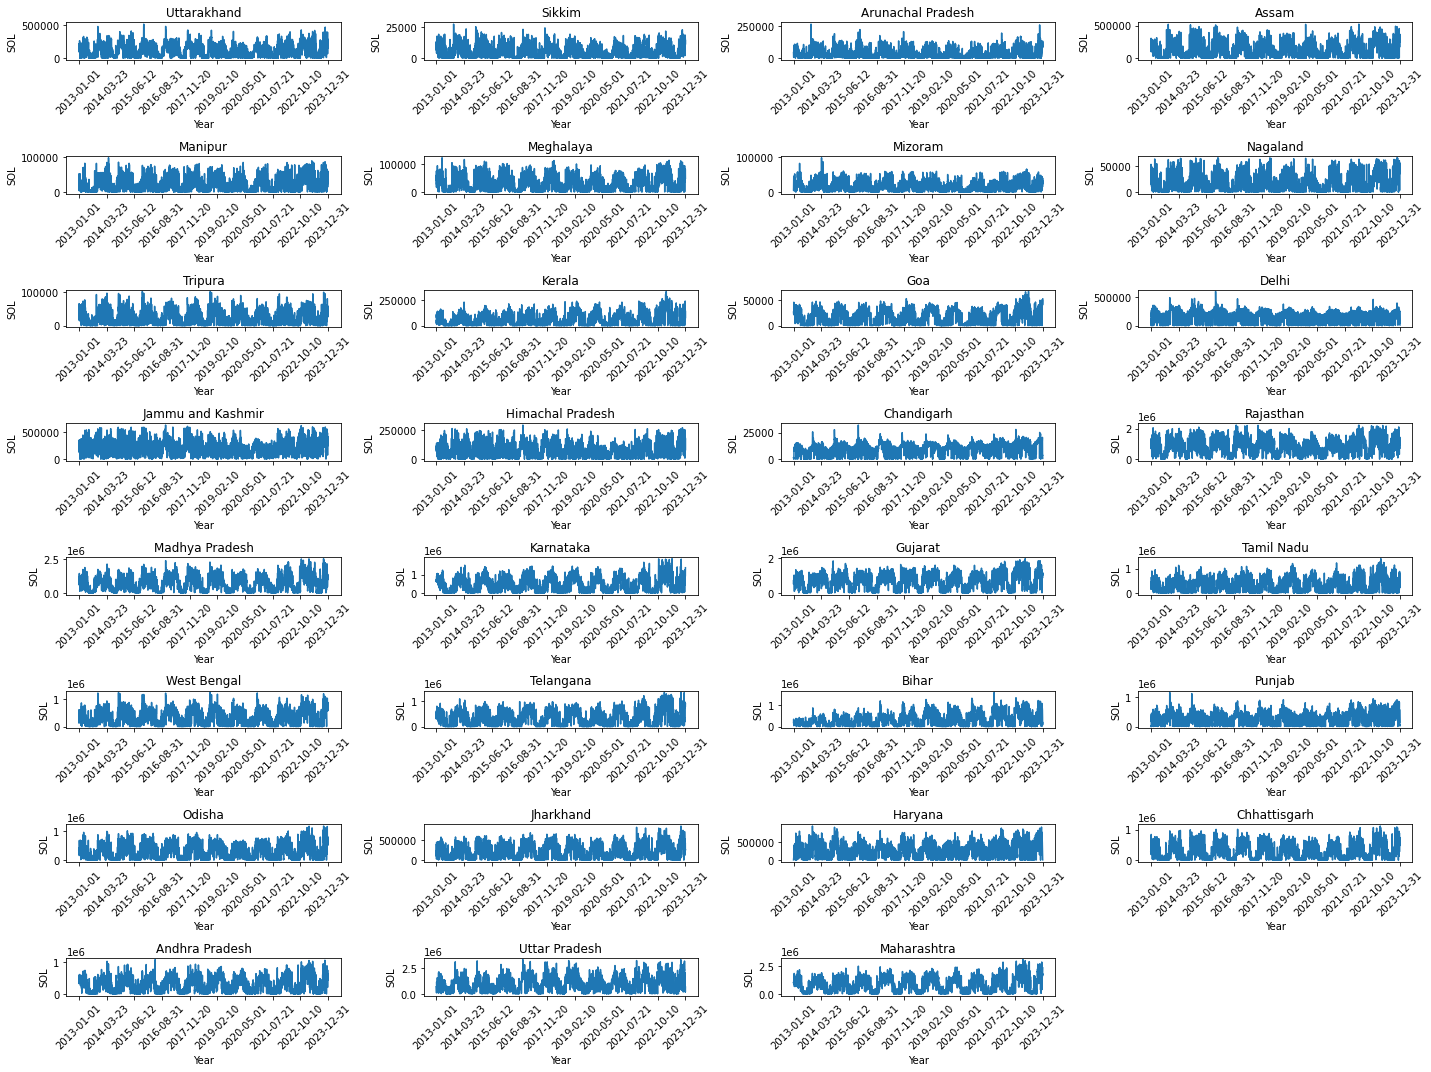

In [11]:
num_states = len(sol.columns)
num_cols = 4
num_rows = -(-num_states // num_cols)  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 15))

axes = axes.flatten()

for i, (state, data) in enumerate(sol.items()):
    ax = axes[i]  
    ax.plot(sol.index, data, label=state)
    ax.set_title(state)

    num_ticks = min(10, len(sol.index))  
    x_ticks = pd.date_range(start=sol.index.min(), end=sol.index.max(), periods=num_ticks)
    ax.set_xticks(x_ticks)

    ax.tick_params(axis='x', rotation=45)

    ax.set_xlabel('Year')
    ax.set_ylabel('SOL')

for j in range(num_states, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [12]:
elec_g1, sol_g1 = clus1['ele'], sol[g1].sum(axis=1)
elec_g2, sol_g2 = clus2['ele'], sol[g2].sum(axis=1)
elec_g3, sol_g3 = clus3['ele'], sol[g3].sum(axis=1)
elec_g4, sol_g4 = clus4['ele'], sol[g4].sum(axis=1)

elec_g1.name = 'elec_g1'
sol_g1.name = 'sol_g1'

elec_g2.name = 'elec_g2'
sol_g2.name = 'sol_g2'

elec_g3.name = 'elec_g3'
sol_g3.name = 'sol_g3'

elec_g4.name = 'elec_g4'
sol_g4.name = 'sol_g4'

In [13]:
df_g1 = pd.merge(sol_g1, elec_g1, on='date', how='inner')
df_g2 = pd.merge(sol_g2, elec_g2, on='date', how='inner')
df_g3 = pd.merge(sol_g3, elec_g3, on='date', how='inner')
df_g4 = pd.merge(sol_g4, elec_g4, on='date', how='inner')

In [14]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences):
            break
        # seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [15]:
def predict_from_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = predictions.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    pred_org = scaler.inverse_transform(predictions)
    y_org = scaler.inverse_transform(y_test)

    print(math.sqrt(mean_squared_error(pred_org, y_org)))

    plt.plot(pred_org, label='Pred')
    plt.plot(y_org, label='Actual')
    plt.legend()
    plt.show()

> ### **Group 1**  
'Uttarakhand', 'Sikkim','Arunachal Pradesh','Assam','Manipur','Meghalaya','Mizoram','Nagaland','Tripura', 'Kerala', 'Goa', 'Delhi', 'Jammu and Kashmir', 'Himachal Pradesh', 'Chandigarh'


C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\1593560330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\1593560330.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))


C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\1593560330.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\1593560330.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 29, 64)         34048     
                                                                 
 flatten (Flatten)           (None, 1856)              0         
                                                                 
 dense (Dense)               (None, 1)                 1857      
                                                                 
Total params: 35,905
Trainable params: 35,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
87/87 [==============================] - 38s 215ms/step - loss: 0.0227 - root_mean_squared_error: 0.1508
Epoch 2/30
87/87 [==============================] - 17s 193ms/step - loss: 0.0050 - root_mean_squared_error: 0.0704
Epoch 3/30
87/87 [==============================] - 14s 162ms/step - loss: 0.00

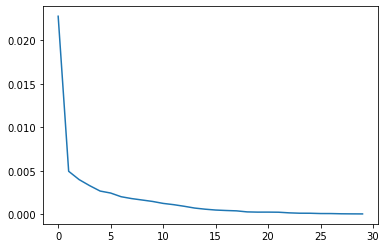

14/14 [==============================] - 2s 35ms/step
18.841133388998884


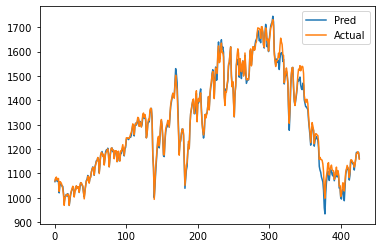

In [16]:
split_index = int(len(df)*0.8)
train, test = df_g1[:split_index], df_g1[split_index:]


scalers = {}

for i in train.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
    scalers['scaler'+i] = scaler

for i in test.columns:
    scaler = scalers['scaler'+i]
    test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))


n_steps = 360

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features, n_seq, n_steps = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq,1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=30)
plt.plot(history.history['loss'])
plt.show()

predict_from_model(model, X_test, y_test, scalers['scalerelec_g1'])

> ### **Group 2**  
'Rajasthan', 'Madhya Pradesh', 'Karnataka', 'Gujarat', 'Tamil Nadu'


C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\1092794164.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\1092794164.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\1092794164.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 29, 64)         34048     
                                                                 
 flatten_1 (Flatten)         (None, 1856)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1857      
                                                                 
Total params: 35,905
Trainable params: 35,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
87/87 [==============================] - 29s 166ms/step - loss: 0.0229 - root_mean_squared_error: 0.1514
Epoch 2/30
87/87 [==============================] - 14s 166ms/step - loss: 0.0072 - root_mean_squared_error: 0.0851
Epoch 3/30
87/87 [==============================] - 14s 161ms/step - loss: 0.

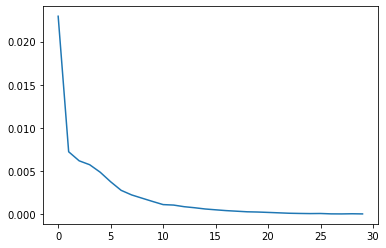

14/14 [==============================] - 2s 32ms/step
10.30412725752923


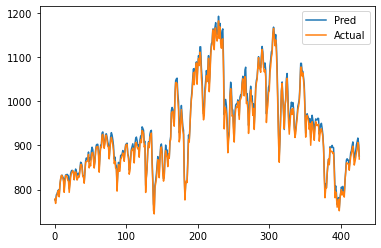

In [17]:
split_index = int(len(df)*0.8)
train, test = df_g2[:split_index], df_g2[split_index:]


scalers = {}

for i in train.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
    scalers['scaler'+i] = scaler

for i in test.columns:
    scaler = scalers['scaler'+i]
    test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))


n_steps = 360

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features, n_seq, n_steps = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq,1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=30)
plt.plot(history.history['loss'])
plt.show()

predict_from_model(model, X_test, y_test, scalers['scalerelec_g2'])

> ### **Group 3**  
'West Bengal', 'Telangana','Bihar', 'Punjab', 'Odisha', 'Jharkhand', 'Haryana', 'Chhattisgarh', 'Andhra Pradesh'

C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\658989518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\658989518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\658989518.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 29, 64)         34048     
                                                                 
 flatten_2 (Flatten)         (None, 1856)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1857      
                                                                 
Total params: 35,905
Trainable params: 35,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
87/87 [==============================] - 27s 139ms/step - loss: 0.0226 - root_mean_squared_error: 0.1504
Epoch 2/30
87/87 [==============================] - 11s 132ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004
Epoch 3/30
87/87 [==============================] - 12s 133ms/step - loss: 0.

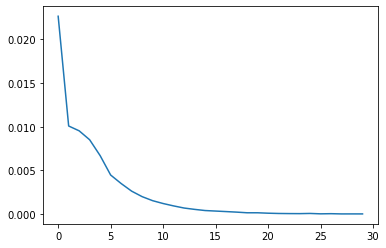

14/14 [==============================] - 2s 29ms/step
9.832136959514312


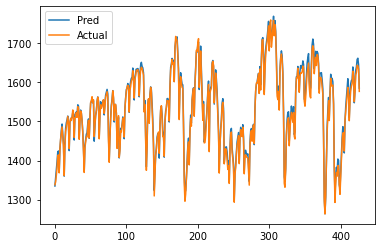

In [18]:
split_index = int(len(df)*0.8)
train, test = df_g3[:split_index], df_g3[split_index:]


scalers = {}

for i in train.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
    scalers['scaler'+i] = scaler

for i in test.columns:
    scaler = scalers['scaler'+i]
    test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))


n_steps = 360

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features, n_seq, n_steps = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq,1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=30)
plt.plot(history.history['loss'])
plt.show()

predict_from_model(model, X_test, y_test, scalers['scalerelec_g3'])

> ### **Group 4**  
'Uttar Pradesh', 'Maharashtra'

C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\2822774558.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\2822774558.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
C:\Users\darsh\AppData\Local\Temp\ipykernel_24748\2822774558.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, 1, 29, 64)         34048     
                                                                 
 flatten_3 (Flatten)         (None, 1856)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1857      
                                                                 
Total params: 35,905
Trainable params: 35,905
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
87/87 [==============================] - 26s 144ms/step - loss: 0.0263 - root_mean_squared_error: 0.1621
Epoch 2/50
87/87 [==============================] - 11s 131ms/step - loss: 0.0068 - root_mean_squared_error: 0.0824
Epoch 3/50
87/87 [==============================] - 12s 135ms/step - loss: 0.

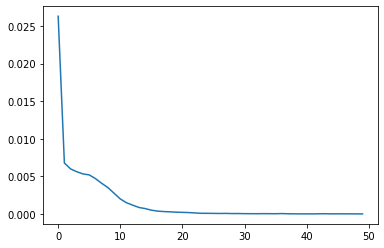

14/14 [==============================] - 5s 49ms/step
1.4353573290798565


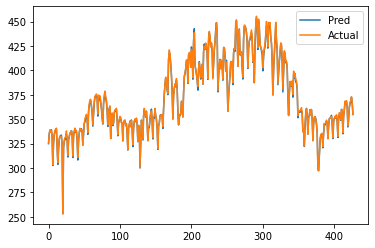

In [19]:
split_index = int(len(df)*0.8)
train, test = df_g4[:split_index], df_g4[split_index:]


scalers = {}

for i in train.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    train[i] = scaler.fit_transform(train[i].values.reshape(-1,1))
    scalers['scaler'+i] = scaler

for i in test.columns:
    scaler = scalers['scaler'+i]
    test[i] = scaler.fit_transform(test[i].values.reshape(-1,1))


n_steps = 360

X_train, y_train = split_sequences(train.values, n_steps)
X_test, y_test = split_sequences(test.values, n_steps)

n_features, n_seq, n_steps = X_train.shape[2], 12, 30

X_train = X_train.reshape((X_train.shape[0], n_seq, 1, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, 1, n_steps, n_features))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq,1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))

print(model.summary())

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=50)
plt.plot(history.history['loss'])
plt.show()

predict_from_model(model, X_test, y_test, scalers['scalerelec_g4'])